# CNN - Style Transfer

利用CNN的特徵萃取特性把風格圖的風格轉移到目標圖案上

### Reference

[論文出處](https://arxiv.org/pdf/1508.06576v2.pdf)  

[原文論文github](https://github.com/keras-team/keras/blob/master/examples/neural_style_transfer.py)

簡單說就是，我們生成原圖的"結構"與期望結果的"結構"的損失函數，與風格圖的"風格"與期望結果的"風格"的損失函數  
利用這兩個損失函數的結合，經過訓練後，得到最小損失函數的特徵，再還原回去原圖，就得到我們要的結果。  

#### Step1. 基本設定

 - base_image_path: 原圖
 - style_reference_image_path: 風格圖
 - iterations: 共要訓練的次數
 - total_variation_weight: 擾動損失權重
 - style_weight: 風格損失函數權重
 - content_weight: 原圖損失函數權重

In [1]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np

import os
import matplotlib.pyplot as plt

from keras.applications import vgg19
from keras import backend as K

ROOT_DIR = os.getcwd()
STYLE_DIR = os.path.join(ROOT_DIR,'STYLE_TRANSFER')
base_image_path = os.path.join(STYLE_DIR,'origin2.jpg')
style_reference_image_path = os.path.join(STYLE_DIR,'style4.jpg')


# these are the weights of the different loss components
total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.02

Using TensorFlow backend.


#### Step2. 資料預處理

利用VGG19的網路來執行風格轉換需要以下的內容:  
原圖、風格圖與目標圖  
而要能夠使得圖片能夠丟進去VGG19  
需要先將圖片轉成TENSOR，這裡定義一個preprcess_image的功能  
並在輸出之後轉成Tensor的變數

還有最後從模型輸出經運算後的圖形需要還原的function  
把維度轉回來  
另外需要做BGR轉RGB與影像中心化轉回  
這是由於VGG19的preprocess_input的mode為caffe時所作的預處理


In [2]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)


# util function to open, resize and format pictures into appropriate tensors
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img


# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))   
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# get tensor representations of our images
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

# this will contain our generated image
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

Instructions for updating:
Colocations handled automatically by placer.


#### Step3. 模型建立

這邊利用VGG19的模型，而輸入的tensor為3張圖像  
分別為: 原圖、風格參考圖、合成圖

In [3]:
model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

#### Step4. 數學模型

這邊的部分來自於論文

在風格損失函數方面，利用gram矩陣: 
![](https://i.imgur.com/sfabL04.jpg)

Gram矩陣為特性為提取，在由此計算來定義風格的損失函數:
![](https://i.imgur.com/uPeImCL.jpg)  
  
這是神來一筆，爬了些文章，理解大致上是這樣:  
Gram matrix是把特徵間倆倆的關係，藉由內積運算來表示出來  
我們對於風格的定義是: 圖案的材質、紋理、顏色等等  
並不包含空間上的位子與形狀，那麼就利用Gram matrix的運算  
只考慮特徵間的相關性  
最後把這相關性跟我們的目標圖片做損失估算就能定義好這部分的損失函數  

而內容的損失函數則是利用均方差計算:  
![](https://i.imgur.com/o4tHTL7.jpg)  

另外定義一個擾動損失，目的是為了讓產生圖有連貫性



In [4]:
# gram matrix for style loss calculation
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


# style loss as papaer describe
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# content loss definition
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


定義好損失函數以後  
在把損失函數加總  
  
在原圖上，是利用VGG19最後一層的Convolution來做損失評估  
 
而在風格損失上，則是利用前面幾層的Convolution層的輸出來做評估  
  
為什麼這樣選擇，可以從原論文來窺探  

![](https://i.imgur.com/Y4vKod9.jpg)


上方部分是風格重建  
下方部分是內容重建  
可以看到越深層的的特徵是越粗糙的(其實也可以從模型的輸出來判斷，經過幾次的pooling後，對資訊的保留是越來越少)  
所以我們利用較模糊的原圖資訊  
與較細緻的材質資訊  
來製作風格圖  

In [5]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# combine all loss
# 1. content loss
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(base_image_features, combination_features)

# 2. style loss
feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    
# 3. variation loss 
loss += total_variation_weight * total_variation_loss(combination_image)

# get the gradients of the generated image wrt the loss
gradiant = K.gradients(loss, combination_image)

outputs=[loss]
outputs+=gradiant
funtions = K.function([combination_image], outputs)


def get_loss_and_grad(img):
    img = img.reshape((1, img_nrows, img_ncols, 3))
    loss, grads = funtions([img])
    grads = grads.flatten().astype('float64')
    return loss, grads


這邊參考原論文的Git定義一個物件來操作loss跟gradient

In [6]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = get_loss_and_grad(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

定義輸入的初始圖，原論文是使用白噪圖來做輸入  
這裡直接使用原始圖當輸入來試試看  
這能夠以更少的訓練次數來快速得到一個不錯的結果  

In [7]:
enter_img = preprocess_image(base_image_path)

共作iterations次數得更新，來看看最後成果  
這裡利用的fmin_l_bfgs_b為Scipy的套件  
是利用L-BFGS做優化的函示，有待研究  
[參考資料](http://www.hankcs.com/ml/l-bfgs.html) 

In [8]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'image_create'
iterations = 20

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    enter_img, min_val, info = fmin_l_bfgs_b(evaluator.loss, enter_img.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)

    img = deprocess_image(enter_img.copy())
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2225118200.0
Image saved as image_create_at_iteration_0.png
Iteration 0 completed in 11s
Start of iteration 1
Current loss value: 1089761900.0
Image saved as image_create_at_iteration_1.png
Iteration 1 completed in 6s
Start of iteration 2
Current loss value: 813770400.0
Image saved as image_create_at_iteration_2.png
Iteration 2 completed in 6s
Start of iteration 3
Current loss value: 713220740.0
Image saved as image_create_at_iteration_3.png
Iteration 3 completed in 6s
Start of iteration 4
Current loss value: 654004740.0
Image saved as image_create_at_iteration_4.png
Iteration 4 completed in 7s
Start of iteration 5
Current loss value: 612039500.0
Image saved as image_create_at_iteration_5.png
Iteration 5 completed in 7s
Start of iteration 6
Current loss value: 585218940.0
Image saved as image_create_at_iteration_6.png
Iteration 6 completed in 7s
Start of iteration 7
Current loss value: 560446000.0
Image saved as image_create_at_iteration_7.png
I

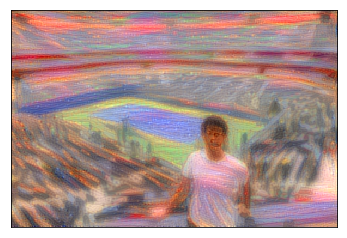

In [9]:
def show_img(img):
    plt.figure()
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

show_img(img)